In [57]:
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt

In [58]:
#read in the data, get normalized adjacency (NxN)
%run helpers_preproc.ipynb
mesh_dir = 'SHREC11/'

label_np = np.array(readLbl(mesh_dir+'labels.txt'))
label_mat_np = np.where(igl.all_pairs_distances(label_np,label_np,False) > 0.5,0,1)
label_mat = torch.tensor(label_mat_np,requires_grad=False)

In [59]:
normed_adjMats_list = []
node_sigs_list = []

for i in range(600):
    fName = 'T' + str(i) + '.obj'
    adj_noscale_read = obj_2_adj_noscale(mesh_dir + fName)
    adj_scaled_read = obj_2_adj(mesh_dir + fName)

    if (adj_scaled_read.shape[0] < 252):
        adj_noscale = np.empty([252,252])
        adj_scaled = np.empty([252,252])
    else:
        adj_noscale = adj_noscale_read
        adj_scaled = adj_scaled_read

    adj_normalized = adj_noscale / np.reshape(np.sum(adj_noscale,axis = 1),[adj_noscale.shape[0],1])

    #node level signal extraction
    node_degs = np.sum(adj_noscale,axis = 0)
    node_neigh_max = np.max(adj_scaled,axis = 0)
    node_neigh_min = np.min(adj_scaled,axis = 0)
    node_neigh_sum = np.sum(adj_scaled,axis = 0)
    node_neigh_mean = np.sum(adj_scaled,axis = 0)

    node_sig = np.stack([node_degs,node_neigh_max,node_neigh_min,node_neigh_sum,node_neigh_mean],axis = 1)
    node_sigs_list.append(node_sig)

    normed_adjMats_list.append(adj_normalized)

In [4]:
normed_adjMats = np.stack(normed_adjMats_list)
node_sigs = np.stack(node_sigs_list)

normed_adjMats = torch.tensor(normed_adjMats,requires_grad=False).float()
node_sigs = torch.tensor(node_sigs,requires_grad=False).float()

normed_adjMats = torch.nan_to_num(normed_adjMats,0,0,0)
node_sigs = torch.nan_to_num(node_sigs,0,0,0)

In [5]:
node_sigs

tensor([[[5.0000, 0.0888, 0.0000, 0.3595, 0.3595],
         [7.0000, 0.1017, 0.0000, 0.4655, 0.4655],
         [6.0000, 0.0920, 0.0000, 0.4395, 0.4395],
         ...,
         [7.0000, 0.1142, 0.0000, 0.5429, 0.5429],
         [6.0000, 0.1352, 0.0000, 0.4959, 0.4959],
         [7.0000, 0.1352, 0.0000, 0.5233, 0.5233]],

        [[5.0000, 0.1061, 0.0000, 0.4014, 0.4014],
         [5.0000, 0.1546, 0.0000, 0.4404, 0.4404],
         [5.0000, 0.2171, 0.0000, 0.5315, 0.5315],
         ...,
         [5.0000, 0.1340, 0.0000, 0.4817, 0.4817],
         [6.0000, 0.1705, 0.0000, 0.7666, 0.7666],
         [5.0000, 0.1284, 0.0000, 0.4872, 0.4872]],

        [[4.0000, 0.1228, 0.0000, 0.3313, 0.3313],
         [5.0000, 0.2132, 0.0000, 0.5203, 0.5203],
         [4.0000, 0.1201, 0.0000, 0.2880, 0.2880],
         ...,
         [5.0000, 0.1041, 0.0000, 0.4604, 0.4604],
         [5.0000, 0.1094, 0.0000, 0.4256, 0.4256],
         [4.0000, 0.0913, 0.0000, 0.3470, 0.3470]],

        ...,

        [[5.0000, 0.

In [6]:
class GCN(torch.nn.Module):
    def __init__(self, widths):
        super().__init__()
        self.f = 5
        self.widths = widths
        self.weights = []
        self.weights.append(torch.autograd.Variable(torch.rand(size = [self.f,widths[0]])-0.5,requires_grad = True))

        for i in range(1,len(self.widths)):
            c = self.widths[i]
            self.weights.append(torch.autograd.Variable(torch.rand((self.widths[i-1],self.widths[i]))-0.5,requires_grad = True))

    def forward(self, adjM,node_sigM):
        curr_output = torch.tanh(torch.matmul(torch.matmul(adjM,node_sigM),self.weights[0])) #nxc
        for i in range(1,len(self.widths)):
            curr_output = torch.tanh(torch.matmul(torch.matmul(adjM,curr_output),self.weights[i])) #nxc

        return curr_output

In [7]:
class NNN(torch.nn.Module):
    def __init__(self, widths):
        super().__init__()
        self.input_shape = 2520
        self.widths = widths
        self.weights = []
        self.weights.append(torch.autograd.Variable(torch.rand(size = [self.input_shape,widths[0]])-0.5,requires_grad = True))

        for i in range(1,len(self.widths)):
            c = self.widths[i]
            self.weights.append(torch.autograd.Variable(torch.rand((self.widths[i-1],self.widths[i]))-0.5,requires_grad = True))

    def forward(self, x):
        x = torch.flatten(x,1,2)
        torch.matmul(x,self.weights[0])
        curr_output = torch.tanh(torch.matmul(x,self.weights[0])) #nxc
        for i in range(1,len(self.widths)):
            curr_output = torch.tanh(torch.matmul(curr_output,self.weights[i])) #nxc

        return curr_output

In [8]:
g = GCN([10,10,10,10])
n = NNN([10,10,10,10])
output1 = g.forward(normed_adjMats,node_sigs)
output2 = n.forward(output1)
print(output1)
print(output2)

tensor([[[-0.1551,  0.0792, -0.1879,  ...,  0.2107,  0.1526,  0.1281],
         [-0.1552,  0.0793, -0.1878,  ...,  0.2107,  0.1526,  0.1282],
         [-0.1538,  0.0763, -0.1872,  ...,  0.2108,  0.1510,  0.1283],
         ...,
         [-0.1530,  0.0738, -0.1868,  ...,  0.2110,  0.1502,  0.1273],
         [-0.1535,  0.0749, -0.1867,  ...,  0.2110,  0.1504,  0.1279],
         [-0.1529,  0.0739, -0.1861,  ...,  0.2110,  0.1495,  0.1284]],

        [[-0.1609,  0.0888, -0.1975,  ...,  0.2099,  0.1671,  0.1148],
         [-0.1640,  0.0960, -0.1989,  ...,  0.2098,  0.1708,  0.1146],
         [-0.1616,  0.0909, -0.1976,  ...,  0.2098,  0.1677,  0.1155],
         ...,
         [-0.1603,  0.0885, -0.1972,  ...,  0.2098,  0.1663,  0.1159],
         [-0.1542,  0.0758, -0.1967,  ...,  0.2094,  0.1612,  0.1148],
         [-0.1613,  0.0905, -0.1975,  ...,  0.2098,  0.1673,  0.1158]],

        [[-0.1613,  0.0902, -0.1962,  ...,  0.2101,  0.1661,  0.1169],
         [-0.1612,  0.0897, -0.1960,  ...,  0

In [9]:
def lossF(features):
    disMat = torch.cdist(features,features)
    sameType = disMat * (label_mat-torch.diag(torch.ones(600)))
    diffType = disMat * (1-label_mat)
    sameTypeMean = torch.sum(sameType) / 12000
    diffTypeMean = torch.sum(diffType) /348000

    sameTypeStd = torch.sum((sameType - sameTypeMean)**2) / 12000
    diffTypeStd = torch.sum((diffType - diffTypeMean)**2) / 348000

    #print(disMat)
    return  sameTypeMean - diffTypeMean + 0.2 * (sameTypeStd + diffTypeStd)

In [60]:
optimizer = optim.Adam(g.weights + n.weights,lr = 0.0001)
for i in range(10000):
    optimizer.zero_grad()
    output = n.forward(g.forward(normed_adjMats,node_sigs))
    loss = lossF(output)
    loss.backward()
    optimizer.step()
    print(loss)

tensor(-2.4778, grad_fn=<AddBackward0>)
tensor(-0.6213, grad_fn=<AddBackward0>)
tensor(-2.2288, grad_fn=<AddBackward0>)
tensor(-2.1794, grad_fn=<AddBackward0>)
tensor(-1.6904, grad_fn=<AddBackward0>)
tensor(-1.7257, grad_fn=<AddBackward0>)
tensor(-2.0248, grad_fn=<AddBackward0>)
tensor(-2.2867, grad_fn=<AddBackward0>)
tensor(-2.3498, grad_fn=<AddBackward0>)
tensor(-2.1862, grad_fn=<AddBackward0>)
tensor(-2.1077, grad_fn=<AddBackward0>)
tensor(-2.1888, grad_fn=<AddBackward0>)
tensor(-2.3151, grad_fn=<AddBackward0>)
tensor(-2.3666, grad_fn=<AddBackward0>)
tensor(-2.3409, grad_fn=<AddBackward0>)
tensor(-2.3131, grad_fn=<AddBackward0>)
tensor(-2.3111, grad_fn=<AddBackward0>)
tensor(-2.3276, grad_fn=<AddBackward0>)
tensor(-2.3593, grad_fn=<AddBackward0>)
tensor(-2.3776, grad_fn=<AddBackward0>)
tensor(-2.3840, grad_fn=<AddBackward0>)
tensor(-2.4118, grad_fn=<AddBackward0>)
tensor(-2.4344, grad_fn=<AddBackward0>)
tensor(-2.4067, grad_fn=<AddBackward0>)
tensor(-2.3781, grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [61]:
disMat = torch.cdist(output,output).flatten()
mask_same = torch.tensor(label_mat - torch.diag(torch.ones(600)),dtype=bool).flatten()
mask_diff = torch.tensor(1 - label_mat,dtype=bool).flatten()
sameComp = disMat[mask_same].detach().numpy()
diffComp = disMat[mask_diff].detach().numpy()
weightsSame = np.ones_like(sameComp) / len(sameComp)
weightsDiff = np.ones_like(diffComp) / len(diffComp)
bins = torch.arange(0,0.1,0.001)

/var/folders/t4/vdzymfw562g8ml8ks_2b5l5r0000gn/T/ipykernel_25938/401933162.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_same = torch.tensor(label_mat - torch.diag(torch.ones(600)),dtype=bool).flatten()
/var/folders/t4/vdzymfw562g8ml8ks_2b5l5r0000gn/T/ipykernel_25938/401933162.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_diff = torch.tensor(1 - label_mat,dtype=bool).flatten()


(array([0.0533334 , 0.03736727, 0.03491089, 0.03280845, 0.03403658,
        0.0329839 , 0.03526287, 0.02859288, 0.03052247, 0.02508456,
        0.02789122, 0.02368122, 0.02280414, 0.02420747, 0.02017289,
        0.01964664, 0.02140239, 0.0161438 , 0.0161438 , 0.01772308,
        0.01351166, 0.01509094, 0.01228333, 0.01210785, 0.01263428,
        0.00947571, 0.0087738 , 0.00859833, 0.0080719 , 0.0080719 ,
        0.00754547, 0.00614166, 0.00772095, 0.00543976, 0.00737   ,
        0.00596619, 0.00649261, 0.00701904, 0.00526428, 0.00508881,
        0.00350952, 0.00579071, 0.00526428, 0.00543976, 0.00473785,
        0.00403595, 0.00473785, 0.00561523, 0.00491333, 0.00508881,
        0.00386047, 0.00526428, 0.003685  , 0.003685  , 0.00386047,
        0.00526428, 0.00403595, 0.00350952, 0.00280762, 0.00333405,
        0.00228119, 0.00228119, 0.00263214, 0.00193024, 0.00263214,
        0.00298309, 0.00175476, 0.00122833, 0.00263214, 0.00157928,
        0.00193024, 0.00087738, 0.00175476, 0.00

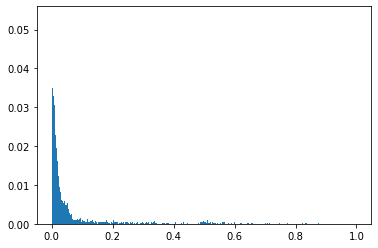

In [62]:
plt.hist(sameComp,bins=np.arange(0,1,0.001),weights=weightsSame,log = False)

(array([0.00534483, 0.00328736, 0.00268391, ..., 0.        , 0.        ,
        0.        ]),
 array([0.000e+00, 1.000e-03, 2.000e-03, ..., 7.997e+00, 7.998e+00,
        7.999e+00]),
 <BarContainer object of 7999 artists>)

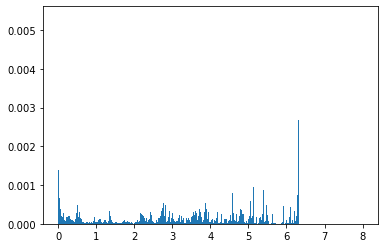

In [65]:
plt.hist(diffComp,bins=np.arange(0,8,0.001),weights=weightsDiff,log = False)